In [18]:
# Libraries
import os
import sys
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_classif, chi2

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Reshape, Flatten

In [19]:
CURRENT_DIR = os.getcwd()
PROJECT_DIR = os.path.dirname(CURRENT_DIR)
MODELS_PATH = os.path.join(PROJECT_DIR, 'models')
ENCODER_PATH = os.path.join(MODELS_PATH, 'encoders')
PIPELINES_PATH = os.path.join(MODELS_PATH, 'pipelines')
LOGS_PATH = os.path.join(MODELS_PATH, 'logs')
LOG_CURRENT = os.path.join(LOGS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
TEST_DATA_PATH = os.path.join(PROJECT_DIR, 
                              'data', 'raw', 'carInsurance_train.csv')

CATEG_PATH = os.path.join(PROJECT_DIR, 'references', 'categorical_columns.txt')
CONTI_PATH = os.path.join(PROJECT_DIR, 'references', 'continous_columns.txt')

DATA_PIPELINE_V1 = os.path.join(PIPELINES_PATH, 'data-pipeline-v1.0')
MODEL_PATH = os.path.join(MODELS_PATH, 'CNN-v1.0.h5')

In [20]:
# adding system path
sys.path.insert(0, PROJECT_DIR)

In [21]:
# import internal function
from src.data import process_pipeline, encoder_pipeline, feature_selection_pipeline

In [22]:
# %% Helper Function
def get_content(txt_file):
    contents = []
    with open(txt_file) as file:
        for line in file:
            contents.append(line.strip())
            
    return contents

# Function to save a trained model
def save_model(model, model_name, folderPath):
    filename = os.path.join(folderPath, f"{model_name}.pkl")
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Function to load a saved model
def load_model(model_name):
    filename = f"{model_name}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as file:
            return pickle.load(file)
    else:
        return None

# Function to evaluate a model
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred.astype('int'))
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")
    return accuracy

# call backs
def callbacks(LOGS_PATH, patience):
    tensorboard_callbacks = TensorBoard(log_dir=LOGS_PATH, histogram_freq=1)
    early_callback = EarlyStopping(monitor='accuracy', patience=patience)
    return [early_callback, tensorboard_callbacks]

In [23]:
df = pd.read_csv(TEST_DATA_PATH)
df = process_pipeline.process_data(df)

In [24]:
# Get list of categorical & continous variable
categ = get_content(CATEG_PATH)
conti = get_content(CONTI_PATH)

In [25]:
# label
X = df.drop(columns=['CarInsurance'])

# load previous data pipeline - if none return means something is wrong
data_pipeline = load_model(DATA_PIPELINE_V1)
X = pd.DataFrame(data_pipeline.transform(X), columns=X.columns.tolist())

#target
y = df['CarInsurance']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [26]:
# create a input and output shape
input_shape = np.shape(X_train)[1:]
model_output = 1 # len(np.unique(y_train, axis=0)) # alternative len(df.target.unique)

In [27]:
input_shape

(28,)

In [28]:
def create_model(input_shape, model_output):
    model = Sequential()
    # input layer
    model.add(Input(shape=input_shape))

    # Reshape for Conv1D
    model.add(Reshape((input_shape[0], 1)))
    
    # CNN
    model.add(Conv1D(64, kernel_size=2, activation='relu'))
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # layer 1
    model.add(Dense(254, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # output
    model.add(Dense(model_output, activation='sigmoid'))
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'],
                 )
    return model

In [29]:
# callbacks
early_callback, tensorboard_callbacks = callbacks(LOGS_PATH, patience=13)

In [30]:
clf = create_model(input_shape, model_output)

# model training + gets evaluation
hist = clf.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_callback]
)

Epoch 1/25


88/88 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - accuracy: 0.7775 - val_loss: 0.0000e+00 - val_accuracy: 0.8083
Epoch 2/25
88/88 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.8175 - val_loss: 0.0000e+00 - val_accuracy: 0.7817
Epoch 3/25
88/88 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.8289 - val_loss: 0.0000e+00 - val_accuracy: 0.7650
Epoch 4/25
88/88 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.8321 - val_loss: 0.0000e+00 - val_accuracy: 0.8058
Epoch 5/25
88/88 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.8325 - val_loss: 0.0000e+00 - val_accuracy: 0.8083
Epoch 6/25
88/88 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.8325 - val_loss: 0.0000e+00 - val_accuracy: 0.8150
Epoch 7/25
88/88 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.8196 - val_loss: 0.000

In [31]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 64)            192       
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 128)           16512     
                                                                 
 flatten_1 (Flatten)         (None, 3328)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 3328)             13312     
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 3328)              0         
                                                      

In [32]:
def model_analysis(training, validation, hist):
    plt.figure()
    plt.plot(hist.history[training])
    plt.plot(hist.history[validation])
    plt.xlabel('epouch')
    plt.legend(['Training_'+training , 'Validation_'+training])
    plt.show()

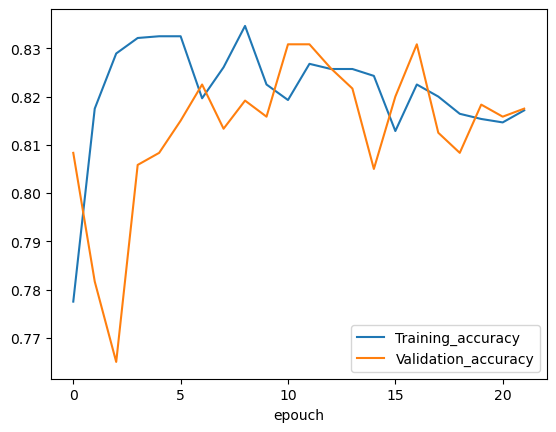

In [33]:
model_analysis('accuracy', 'val_accuracy', hist)
clf.save(MODEL_PATH)

In [34]:
evaluate_model(clf, 'keras', X_test, y_test)

38/38 [==============================] - 0s 3ms/step
keras - Test Accuracy: 0.8158


0.8158333333333333